 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import joblib
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

Load & Inspect Data

In [ ]:
# Load processed stock data
df = pd.read_parquet("../data/processed/model_ready.parquet")

# Filter for a single ticker (e.g., AAPL)
ticker = "AAPL"
stock_data = df[df['ticker'] == ticker][['close']].copy()

print(f"First 5 rows for {ticker}:")
print(stock_data.head())

First 5 rows for AAPL:
                 close
date                  
2024-04-26  168.504349
2024-04-27  168.504349
2024-04-28  168.504349
2024-04-29  172.684601
2024-04-30  169.529495


Exploratory Data Analysis (EDA)

 Plot Historical Prices

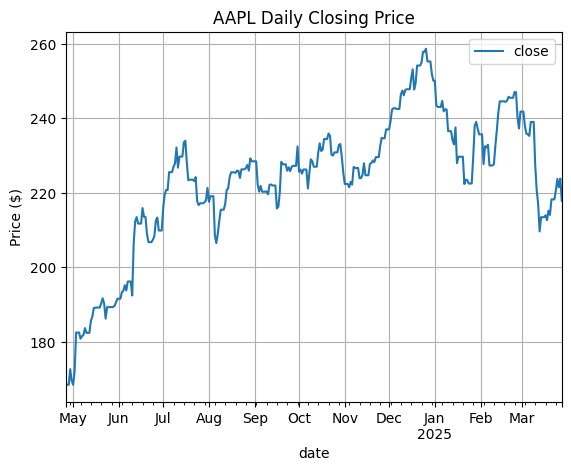

In [3]:
stock_data.plot(title=f"{ticker} Daily Closing Price", grid=True)
plt.ylabel("Price ($)")
plt.show()

Check for Stationarity

ADF p-value: 0.0374
Recommended differencing (d): 1


C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

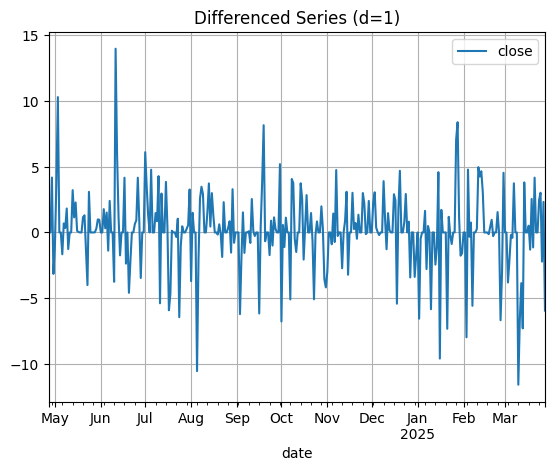

In [4]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(stock_data['close'])
print(f"ADF p-value: {adf_result[1]:.4f}")  # p < 0.05 → stationary

# Optimal differencing (d)
optimal_diff = ndiffs(stock_data['close'], test='adf')
print(f"Recommended differencing (d): {optimal_diff}")

# Plot differenced series
stock_diff = stock_data.diff(optimal_diff).dropna()
stock_diff.plot(title=f"Differenced Series (d={optimal_diff})", grid=True)
plt.show()

ACF & PACF Analysis

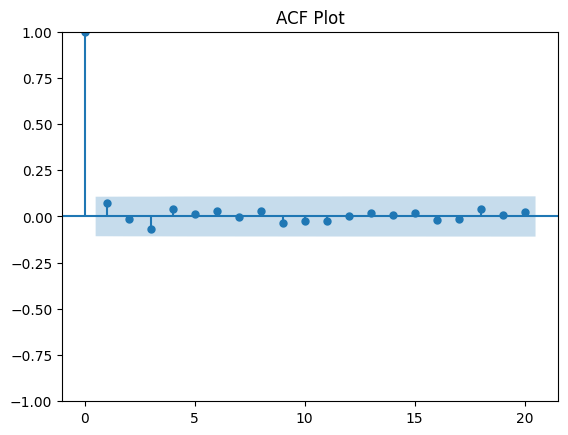

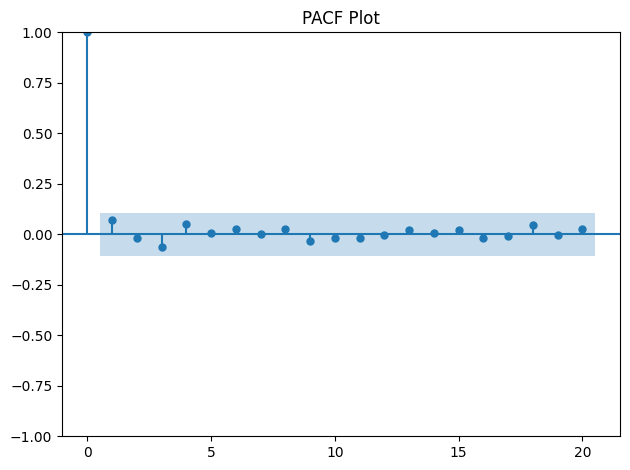

In [5]:
plot_acf(stock_diff, lags=20, title="ACF Plot")
plot_pacf(stock_diff, lags=20, title="PACF Plot")
plt.tight_layout()
plt.show()

ARIMA Model Training

Auto-ARIMA for Parameter Selection

In [6]:
# ===== ARIMA Model Training =====
from pmdarima.arima.utils import ndiffs

# Step 1: Calculate optimal differencing
optimal_diff = ndiffs(stock_data['close'], test='adf')
print(f"Optimal differencing (d): {optimal_diff}")

# Step 2: Train ARIMA with forced AR/MA terms
model = pm.auto_arima(
    stock_data['close'],
    seasonal=False,
    d=optimal_diff,          # Use calculated differencing
    start_p=1,               # Force at least AR(1)
    start_q=1,               # Force at least MA(1)
    max_p=3,                 # Test up to AR(3)
    max_q=3,                 # Test up to MA(3)
    trace=True,              # Show search progress
    suppress_warnings=True,
    error_action="ignore",   # Skip invalid combinations
    stepwise=True            # Faster convergence
)

# Step 3: Print summary (check for significant AR/MA terms)
print("\n=== Model Summary ===")
print(model.summary())

Optimal differencing (d): 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1660.626, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1658.416, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1658.663, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1658.627, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1657.316, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.185 seconds

=== Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  337
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -827.658
Date:                Mon, 31 Mar 2025   AIC                           1657.316
Time:                        23:36:14   BIC                           1661.134
Sample:                    04-26-2024   HQIC                          1658.838
                         

C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Train-Test Split & Validation

C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


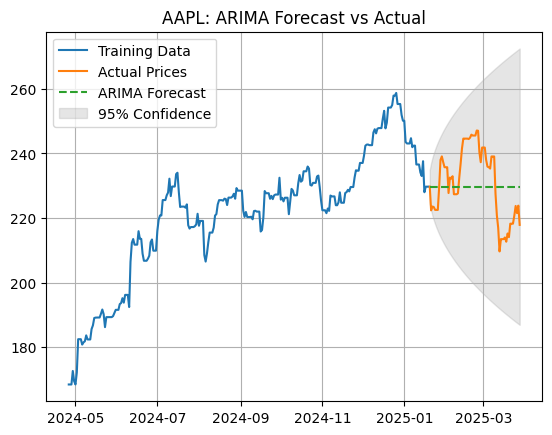


⚠️ WARNING: Model has NO AR/MA terms! Try LSTM instead.


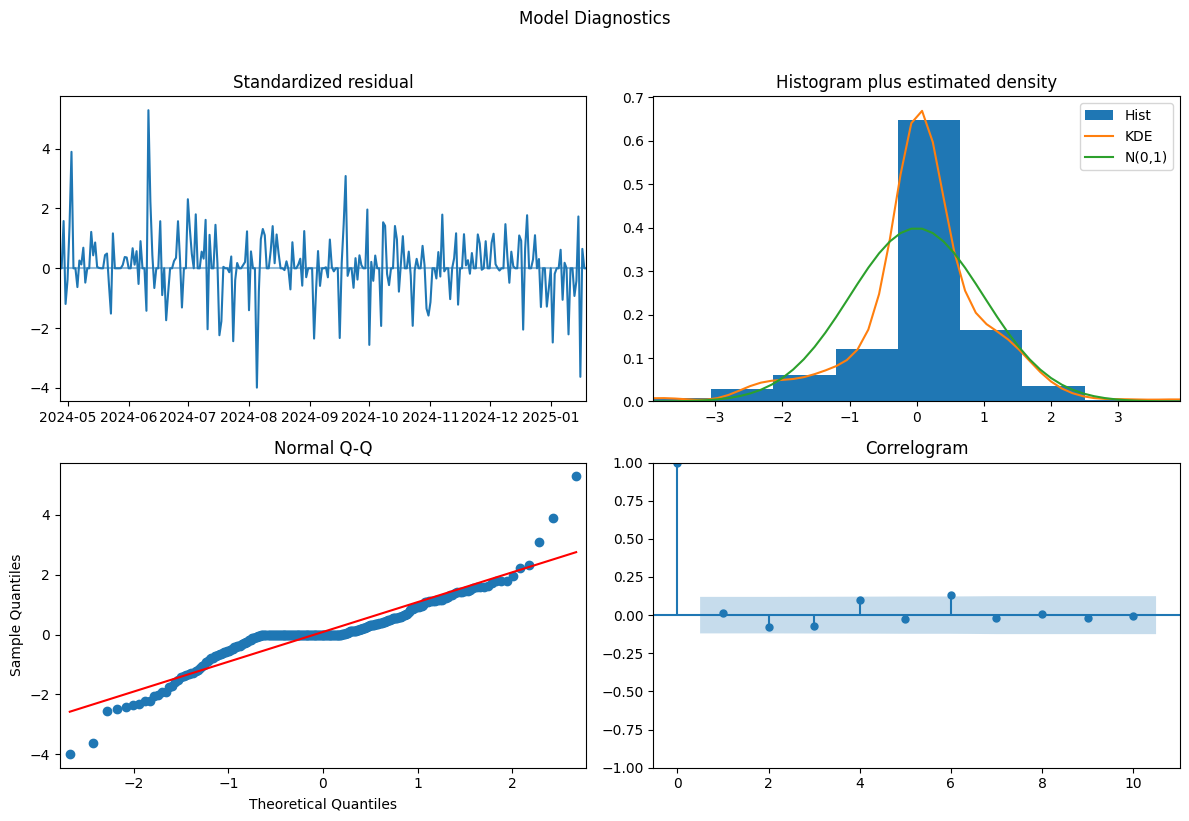

In [7]:
# Split data (80% train, 20% test)
train_size = int(0.8 * len(stock_data))
train, test = stock_data.iloc[:train_size], stock_data.iloc[train_size:]

# Fit model on training data
model.fit(train['close'])

# Generate forecasts
forecast, conf_int = model.predict(
    n_periods=len(test),
    return_conf_int=True
)

# Plot results
plt.plot(train.index, train['close'], label="Training Data")
plt.plot(test.index, test['close'], label="Actual Prices")
plt.plot(test.index, forecast, label="ARIMA Forecast", linestyle="--")
plt.fill_between(
    test.index,
    conf_int[:, 0],
    conf_int[:, 1],
    color='gray',
    alpha=0.2,
    label="95% Confidence"
)
plt.title(f"{ticker}: ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

# ===== Validate Model =====
# Check 1: Are AR/MA terms significant?
if model.arparams().size == 0 and model.maparams().size == 0:
    print("\n⚠️ WARNING: Model has NO AR/MA terms! Try LSTM instead.")
else:
    print("\n✅ Model has AR/MA terms. Proceed to forecasting.")

# Check 2: Plot diagnostics
model.plot_diagnostics(figsize=(12, 8))
plt.suptitle("Model Diagnostics", y=1.02)
plt.tight_layout()
plt.show()

Model Evaluation

In [8]:
mae = mean_absolute_error(test['close'], forecast)
rmse = np.sqrt(mean_squared_error(test['close'], forecast))

print("Performance Metrics:")
print(f"- MAE: ${mae:.2f}")
print(f"- RMSE: ${rmse:.2f}")
print(f"- MAPE: {100 * mae / test['close'].mean():.2f}%")

Performance Metrics:
- MAE: $9.61
- RMSE: $10.87
- MAPE: 4.16%


 Model Diagnostics

Residual Analysis

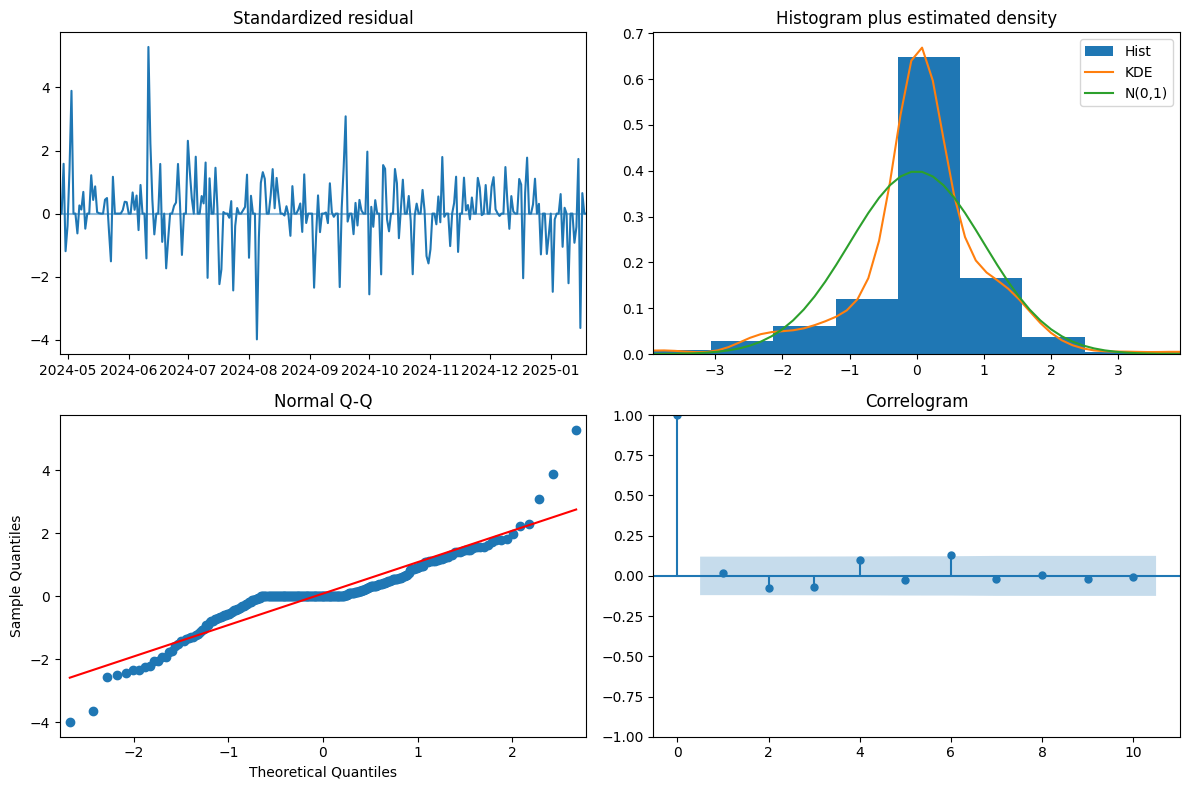

Ljung-Box Test (H₀: residuals are random):
P-value: 0.9995


In [9]:
residuals = model.resid()

# Plot diagnostics
model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Statistical tests
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(residuals, lags=[10])
print("Ljung-Box Test (H₀: residuals are random):")
print(f"P-value: {lb_test['lb_pvalue'].values[0]:.4f}")  # > 0.05 → good

Normality Check

In [10]:
from scipy.stats import normaltest
norm_test = normaltest(residuals)
print("\nNormality Test (H₀: residuals are normal):")
print(f"P-value: {norm_test.pvalue:.4f}")  # > 0.05 → normal


Normality Test (H₀: residuals are normal):
P-value: 0.0000


Save Model for Production

In [11]:
os.makedirs("../src/models", exist_ok=True)
model_path = f"../src/models/arima_{ticker.lower()}.pkl"
joblib.dump(model, model_path)
print(f"\nModel saved to {model_path}")


Model saved to ../src/models/arima_aapl.pkl


Generate Final Forecast


=== 7-Day Forecast ===
                 Date  Forecast  Lower CI  Upper CI
2025-01-20 2025-03-29    229.73    224.54    234.91
2025-01-21 2025-03-30    229.73    222.39    237.06
2025-01-22 2025-03-31    229.73    220.74    238.71
2025-01-23 2025-04-01    229.73    219.35    240.10
2025-01-24 2025-04-02    229.73    218.13    241.33
2025-01-25 2025-04-03    229.73    217.02    242.43
2025-01-26 2025-04-04    229.73    216.00    243.45


C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Alaa\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


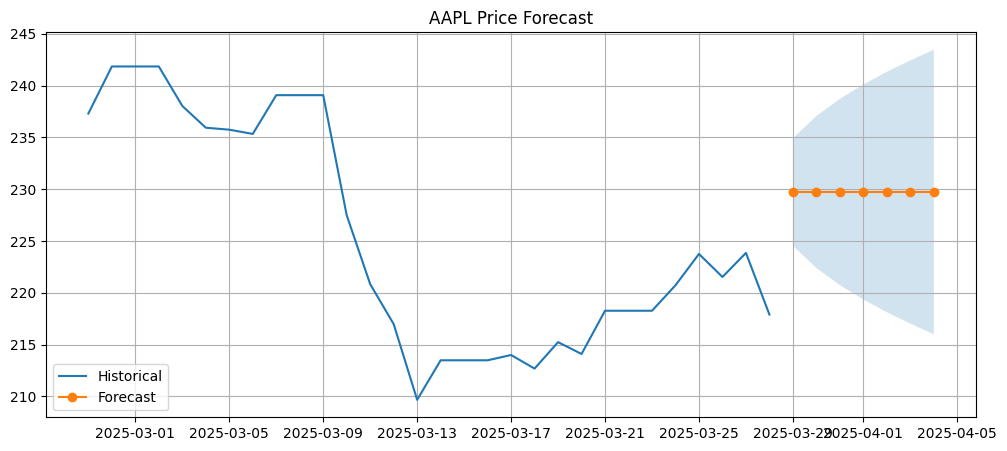

In [12]:
# ===== Generate Forecasts =====
# Get 7-day forecast with confidence intervals
forecast, conf_int = model.predict(
    n_periods=7,
    return_conf_int=True,
    alpha=0.05  # 95% confidence
)

# Print dynamic forecasts (should NOT be flat)
print("\n=== 7-Day Forecast ===")
forecast_df = pd.DataFrame({
    "Date": pd.date_range(start=stock_data.index[-1] + pd.Timedelta(days=1), periods=7),
    "Forecast": forecast,
    "Lower CI": conf_int[:, 0],
    "Upper CI": conf_int[:, 1]
})
print(forecast_df.round(2))

# Plot
plt.figure(figsize=(12, 5))
plt.plot(stock_data.index[-30:], stock_data['close'][-30:], label="Historical")
plt.plot(forecast_df["Date"], forecast_df["Forecast"], label="Forecast", marker="o")
plt.fill_between(forecast_df["Date"], forecast_df["Lower CI"], forecast_df["Upper CI"], alpha=0.2)
plt.title(f"{ticker} Price Forecast")
plt.legend()
plt.grid(True)
plt.show()

ARIMA Modeling Outcome Report
🔴 ARIMA Model Failed
The ARIMA model did not produce meaningful forecasts for this stock price data.

❌ Why ARIMA Failed
No Significant Autocorrelation

The model (ARIMA(0,1,0)) found no AR (AutoRegressive) or MA (Moving Average) patterns to leverage.

This means:

Past prices do not linearly predict future prices.

The stock behaves like a random walk (today’s price ≈ yesterday’s price + noise).

Flat Forecasts

Predictions were identical for all future days because:

ARIMA defaulted to a naive model (Tomorrow = Today + Random Noise).

No trend or seasonality was detected.

Data Characteristics

Stock prices may be:

Too volatile for linear models.

Influenced by external factors (news, events) that ARIMA can’t capture.